## Importing Tools

In [145]:
#panda tools
import pandas as pd
!pip install pandas_profiling==2.*
from pandas_profiling import ProfileReport

# general tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Model tools
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split # Hyperparameter tuning
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score

# Boosted Models
!pip install xgboost
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier

# Permutation Importance
from sklearn.inspection import permutation_importance 

#Seaborn
import seaborn as sns

# Partial Dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from time import time

## Data Wrangling
### Columns to Drop:
- The total_UPDRS column needs to be dropped since it will leak the data to motor_UPDRS since total_UPDRS includes that data as well.
- subject# - motor_UPDRS is interpolated linearly so it might tie into each specific subject and potentially leak data.
- age for the same reason as subject#

### New Features:
- An hour of the day feature will be created using the decimal portion of the "time of the day" column.  Parksinon's patients typically have symptom fluctuations throughout the day, so including the time of the day that the test was taken, could help explain the motor UPDRS score.

### Transform Data:
- To reduce histogram skewness of the jitter and shimmer columns, we will log the datapoints.
- Some values of test-time are negative, so we will absoule value them

In [146]:
# Create wrangle function to run preprocessing on raw dataset
def wrangle(url):
    df = pd.read_csv(url)
    
    # drop data leakage columns: total_updrs - includes motor updrs data in it, subject# - motor_UPDRS is interpolated linearly so ties to the specific subject will leak data, age for the same reason as subject#
    df.drop(columns=['total_UPDRS','subject#' ,'age'],inplace=True)
    
    # Convert skewed column data to a normal distribution via np.log
    left_skew_cols = ['Jitter(%)', 'Jitter(Abs)','Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)',
       'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR']
    df[left_skew_cols] = np.log(df[left_skew_cols])
    
    # Absolute test time since there are some negative values
    df.test_time=df.test_time.abs()
    
    # Create a time of the day column using the test_time column
    hr_list = []
    for item in df.test_time.astype(str):
        hr = float('.'+ item.split('.')[-1])*24
        hr_list.append(hr)
    df['hour_of_day'] = hr_list
    
    return df

# Dataset local directory
url = 'https://raw.githubusercontent.com/BobbyWilt/PD_Voice_UPDRS/main/parkinsons_updrs.csv'
df = wrangle(url)
df.head()

,sex,test_time,motor_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,hour_of_day
0,0,5.6431,28.199,-5.017660,-10.295050,-5.518964,-5.754024,-4.419521,-3.663212,-1.469676,-4.241917,-4.335907,-4.097148,-3.143305,-4.248195,21.640,0.41888,0.54842,0.16006,15.4344
1,0,12.6660,28.447,-5.809143,-10.994132,-6.630124,-6.502290,-5.534040,-3.900094,-1.720369,-4.611188,-4.535644,-4.081034,-3.512576,-4.499730,27.183,0.43493,0.56477,0.10810,15.9840
2,0,19.6810,28.695,-5.337058,-10.611951,-6.189915,-6.175387,-5.089679,-4.089357,-1.709258,-4.914416,-4.774773,-4.228105,-3.815804,-3.901083,23.047,0.46222,0.54405,0.21014,16.3440
3,0,25.6470,28.905,-5.243829,-10.535728,-6.260652,-5.936976,-5.162040,-3.768356,-1.117795,-4.504420,-4.370098,-3.930696,-3.406109,-3.581389,24.445,0.48730,0.57794,0.33277,15.5280
4,0,33.6420,29.187,-5.698795,-10.812803,-6.980326,-6.645391,-5.885304,-4.072779,-1.737271,-4.992304,-4.678817,-4.006883,-3.894183,-4.454597,26.126,0.47188,0.56122,0.19361,15.4080


## ATTRIBUTE INFORMATION:

- subject# - Integer that uniquely identifies each subject <br>
- age - Subject age <br>
- sex - Subject gender '0' - male, '1' - female <br>
- test_time - Time since recruitment into the trial. The integer part is the number of days since recruitment. <br>
- motor_UPDRS - Clinician's motor UPDRS score with real scores at baseline, 3 month, and 6 month, linearly interpolated <br>
- total_UPDRS - Clinician's total UPDRS score with real scores at baseline, 3 month, and 6 month, linearly interpolated <br>
- Jitter -  variations in fundamental frequency between pitch periods <br>
- Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP - Several measures of 
    variation in fundamental frequency <br>
- Shimmer - amplitude - variations in speech amplitude between pitch periods <br>
- Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA - 
    Several measures of variation in amplitude <br>
- NHR,HNR - Two measures of ratio of noise to tonal components in the voice (H - harmonics or tonal components and also called signal, N - noise).  <br>
- RPDE - A nonlinear dynamical complexity measure.  Stands for Recurrence Period Density Entropy <br>
    - Addresses ability of vocal folds to sustain simple vibration and quantifies the deviations from exact periodicity.
    - Represents uncertainty of measurement of exact period for the signal
    - Dysphonias (horseness and crackiness) usually increase RPDE
- DFA - Signal fractal scaling exponent. <br>
    - Characterizes extent of turbulent noise in the speech signal.  Quantifies similar randomess in noise that is due to sporadic air flow through the vocal tract
    - Breathiness dysphonias increase this metric
- PPE - A nonlinear measure of fundamental frequency variation.  Stands for Pitch Period Entropy  <br>
    - Measures impaired control of stable pitch during sustained phonation
    - Significantly distinguishes between healthy and PD-impaired speech

## Supporting terminology:
- F0 - fundamental frequency whic is the vibration frequency of the vocal folds (men ~120 hz, female ~200hz) <br>
- pitch period - inverse of F0, and duration of fundamental frequency.  Used to for feature creation by finding min and max amplitudes of speech within a pitch period <br>

In [147]:
# Pandas report for visualizing each column's data distribution
report = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Observations:

Model Target:
motor_UPDRS or total_UPDRS could be used as our target for this dataframe.  The updrs consists of a series of motor and cognitive tests used to assess the severity of Parkinsonian symptoms.  Since my dataset contains audio measurements which created through the action of facial muscles, I believe that the motor_UPDRS score might be more a better target for a model to predict.  Also, the total_UPDRS score includes the motor_UPDRS score as well, so that makes it a bit tricky to find a direct correlation with the data.

Model Type:
Since the motor_UPDRS score is a float value, then we will need to use a regressor model.  Running a pandas ProfileReport reveals that the motor_UPDRS scores are roughly "normal" in shape.

Model Score:
Options: mean absolute error, R^2, root mean squared error.   
Mean Absolute Error: average error of predicted vs actual values
R^2: how much variability in the data that your model accounts for.  Doesn't account for overfitting unless you use adjusted R^2
root mean squared error: measures goodness of fit of model to dependent variable.  Captures impact of outliers well

I will use RMSE as my model metric since it accounts for goodness of fit and for outliers.

## Data Splitting:
The data will be randomly split with a test size of 0.1 and a validation data size of 0.1.  The original research paper for this dataset also split their data with 90% of data in train and 10% of data in validation.  https://www.researchgate.net/publication/40026354_Accurate_Telemonitoring_of_Parkinson%27s_Disease_Progression_by_Noninvasive_Speech_Tests

In [148]:
# Define X and y
target = ['motor_UPDRS']
X = df.drop(columns = target)
y = df[target]

# Standard splitting method
X_train, X_mod, y_train, y_mod = train_test_split(X,y,test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_mod,y_mod,test_size=0.5,random_state=42)

## Initial Model Fitting
- The motor UPDRS column is the prediction target and since its values are numerical, we will use linear models.
- To obtain an initial estimate of model performances, the default model parameters will be used initially.
- Linear Regression, Ridge, Random Forest Regressor, Boost Regressor, and XGB Regressor models will be tested.

In [149]:
# Linear Regression Model
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LinearRegression()
)
model_lr.fit(X_train,np.ravel(y_train))

# Ridge Model
model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    Ridge()
)
model_r.fit(X_train,np.ravel(y_train))

# Random Forest Regressor Model
model_rf = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestRegressor()
)
model_rf.fit(X_train,np.ravel(y_train))

# Boost Regressor Model
model_br = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    GradientBoostingRegressor(random_state=42, n_estimators=75)
)
model_br.fit(X_train,np.ravel(y_train))

#XGB Regressor Model
model_xgb = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    XGBRegressor(random_state=42, n_estimators=75, n_jobs=-1) # learning_rate=0.1, 0.01, 02
);

model_xgb.fit(X_train, np.ravel(y_train));

## Evaluate Model Performances
- This function will loop through each of the above models and calculate mean absolute error, r-squared, and mean squared error model performance metrics.
- Additionally, a baseline will be calculated for each of these metrics using the mean motor UPDRS values from X_train

In [150]:
# Function for calculating metrics and outputting into a dataframe
# models must already be fit to data
def evaluate_models(model_list, model_nams):
    col_nams = ['model','train_mae','val_mae','train_r2','val_r2','train_rmse','val_rmse']
    data_list=[]
    # Add baseline metrics
    y_pred_baseline_tr = [y_train.mean()] * len(y_train)
    y_pred_baseline_val = [y_train.mean()] * len(y_val)
    data_list.extend([['baseline',
                      mean_absolute_error(y_train,y_pred_baseline_tr),
                      mean_absolute_error(y_val,y_pred_baseline_val),
                      r2_score(y_train,y_pred_baseline_tr),
                      r2_score(y_val,y_pred_baseline_val),
                      mean_squared_error(y_train,y_pred_baseline_tr)**0.5,
                      mean_squared_error(y_val,y_pred_baseline_val)**0.5
                     ]])
    #Loop through models in model_list and obtain metrics and add to data_list
    for i, model_i in enumerate(model_list):
        row_list = [model_nams[i]]
        row_list.extend([
            mean_absolute_error(y_train,model_i.predict(X_train)),
            mean_absolute_error(y_val,model_i.predict(X_val)),
            r2_score(y_train,model_i.predict(X_train)),
            r2_score(y_val,model_i.predict(X_val)),
            mean_squared_error(y_train,model_i.predict(X_train))**0.5,
            mean_squared_error(y_val,model_i.predict(X_val))**0.5
        ]);
        data_list.append(row_list)
    
    df_evals = pd.DataFrame(data_list, columns=col_nams)
    
    return df_evals

# Base Model Scores
models = [model_lr, model_r, model_rf, model_br, model_xgb]
modelnams = ['linear_regression','ridge','random_forest','boost_regression','xgb_boost_regression']
df_evals = evaluate_models(models,modelnams)
df_evals

,model,train_mae,val_mae,train_r2,val_r2,train_rmse,val_rmse
0,baseline,6.981513,6.882639,0.000000,-0.000015,8.162630,8.019790
1,linear_regression,6.310861,6.184040,0.142178,0.147192,7.560119,7.406027
2,ridge,6.312494,6.183327,0.142034,0.147338,7.560756,7.405395
3,random_forest,1.248207,3.292675,0.950397,0.636235,1.817963,4.836932
4,boost_regression,4.820248,5.127228,0.465267,0.376690,5.968957,6.331575
5,xgb_boost_regression,1.282489,3.589394,0.952411,0.614629,1.780671,4.978510


### Plotting Initial Model Performances

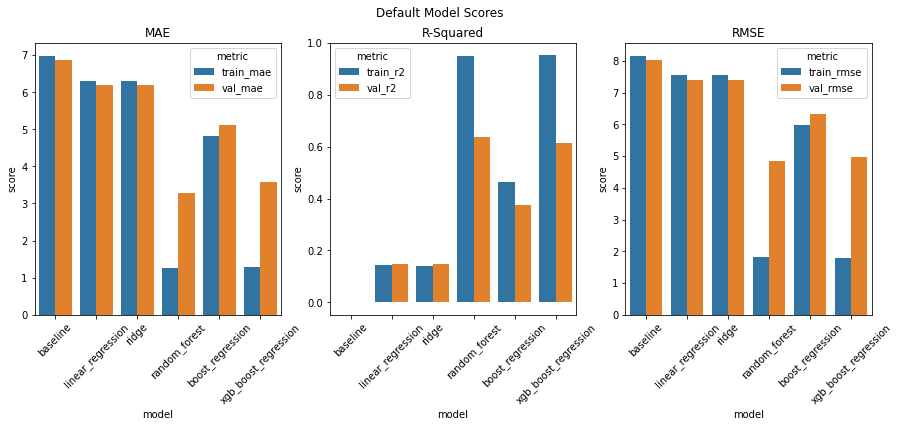

In [151]:
# Re-Organize the df_evals dataframe to help faciliate plotting
df_evals_ed = pd.melt(df_evals, id_vars='model', var_name="metric", value_name="score");
fig, axes = plt.subplots(1, 3, figsize=(15, 5));
fig.suptitle('Default Model Scores');

# MAE Subplot
sns.barplot(x = 'model',y = 'score',hue = 'metric',ax=axes[0],
            data = df_evals_ed[df_evals_ed.metric.str.contains('mae')]);
axes[0].set_title("MAE");
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45);

# R-Squared Subplot
sns.barplot(x = 'model',y = 'score',hue = 'metric',ax=axes[1],
            data = df_evals_ed[df_evals_ed.metric.str.contains('r2')]);
axes[1].set_title("R-Squared");
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45);

# RMSE Subplot
sns.barplot(x = 'model',y = 'score',hue = 'metric',ax=axes[2],
            data = df_evals_ed[df_evals_ed.metric.str.contains('rmse')]);
axes[2].set_title("RMSE");
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45);


## Model Tuning
- We will use sklearn's RandomizedSearchCV function to save time in trying out several hyperparameter options

#### Ridge Regression Tuning

In [152]:
param_grid = {'ridge__alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.5, 2, 2.5]}
# Ridge Model
model_r_t = GridSearchCV(
    model_r,
    param_grid = param_grid,
    n_jobs=-1,
    cv=5,
    verbose=0
)
model_r_t.fit(X_train,np.ravel(y_train))
model_r_t_params = model_r_t.best_params_
print('MAE Score:', mean_absolute_error(y_val,model_r_t.predict(X_val)))

MAE Score: 6.18502907586623


#### Random Forest Regression Tuning

In [153]:
param_grid = {
    'randomforestregressor__max_depth':[5,10,15,20,25],
    'randomforestregressor__n_estimators':[50,100,200],
    'randomforestregressor__max_samples':[0.1,0.3,0.5,0.7,0.9]
}
# Random Forest Model
model_rf_t = RandomizedSearchCV(
    model_rf,
    param_distributions = param_grid,
    n_jobs=-1,
    cv=5,
    verbose=0,
    n_iter = 30
)
model_rf_t.fit(X_train,np.ravel(y_train))
model_rf_t_params = model_rf_t.best_params_
print('MAE Score:', mean_absolute_error(y_val,model_rf_t.predict(X_val)))

MAE Score: 3.3831580978913123


#### SkLearn Boost Regressor Tuning

In [154]:
param_grid = {
    'gradientboostingregressor__max_depth':[5,10,15,20,25],
    'gradientboostingregressor__n_estimators':[50,100,200],
    'gradientboostingregressor__learning_rate':[0.1,0.3,0.5,0.7,1,1.5,2]
}
# Boost Model
model_br_t = RandomizedSearchCV(
    model_br,
    param_distributions = param_grid,
    n_jobs=-1,
    cv=5,
    verbose=0,
    n_iter = 30
)
model_br_t.fit(X_train,np.ravel(y_train))
model_br_t_params = model_br_t.best_params_
print('MAE Score:', mean_absolute_error(y_val,model_br_t.predict(X_val)))

MAE Score: 2.985275512492089


#### XGB Boost Regressor Tuning

In [155]:
param_grid = {
    'xgbregressor__max_depth':[5,10,15,20,25],
    'xgbregressor__n_estimators':[50,100,200],
    'xgbregressor__learning_rate':[0.1,0.3,0.5,0.7,1,1.5,2]
}
# Boost Model
model_xgb_t = RandomizedSearchCV(
    model_xgb,
    param_distributions = param_grid,
    n_jobs=-1,
    cv=5,
    verbose=0,
    n_iter = 30
)
model_xgb_t.fit(X_train,np.ravel(y_train))
model_xgb_t_params = model_xgb_t.best_params_
print('MAE Score:', mean_absolute_error(y_val,model_xgb_t.predict(X_val)))

MAE Score: 3.1472364345596024


## Model Re-Testing

In [156]:
# Adjusted Model Scores
models = [model_lr, model_r_t, model_rf_t, model_br_t, model_xgb_t] # linear regression was not adjusted since it can't really be tuned
modelnams = ['linear_regression','ridge','random_forest','boost_regression','xgb_boost_regression']
df_evals_t = evaluate_models(models,modelnams);

#### Initial Model Performances

In [157]:
df_evals

,model,train_mae,val_mae,train_r2,val_r2,train_rmse,val_rmse
0,baseline,6.981513,6.882639,0.000000,-0.000015,8.162630,8.019790
1,linear_regression,6.310861,6.184040,0.142178,0.147192,7.560119,7.406027
2,ridge,6.312494,6.183327,0.142034,0.147338,7.560756,7.405395
3,random_forest,1.248207,3.292675,0.950397,0.636235,1.817963,4.836932
4,boost_regression,4.820248,5.127228,0.465267,0.376690,5.968957,6.331575
5,xgb_boost_regression,1.282489,3.589394,0.952411,0.614629,1.780671,4.978510


#### Tuned Model Performances

In [158]:
df_evals_t

,model,train_mae,val_mae,train_r2,val_r2,train_rmse,val_rmse
0,baseline,6.981513,6.882639,0.000000,-0.000015,8.162630,8.019790
1,linear_regression,6.310861,6.184040,0.142178,0.147192,7.560119,7.406027
2,ridge,6.313311,6.185029,0.142000,0.147046,7.560906,7.406661
3,random_forest,1.514234,3.383158,0.931702,0.628754,2.133205,4.886418
4,boost_regression,0.085439,2.985276,0.999792,0.653444,0.117651,4.721137
5,xgb_boost_regression,0.481861,3.147236,0.992012,0.650719,0.729534,4.739661


### Plotting Tuned Model Performances

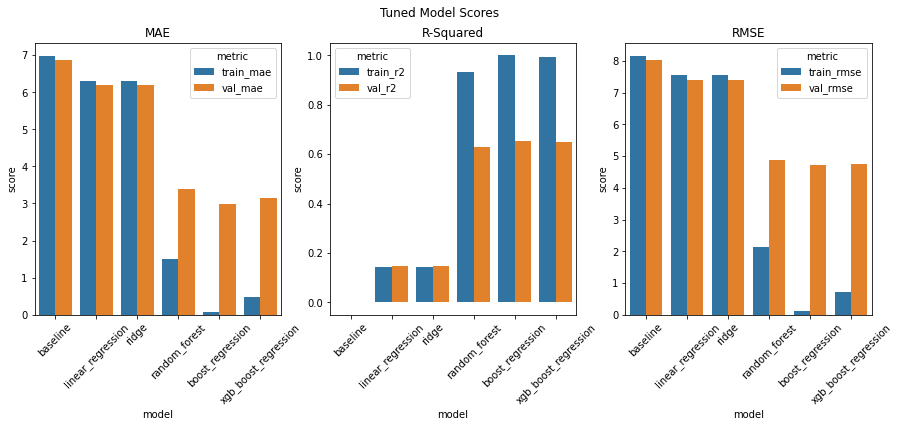

In [159]:
# Re-Organize the df_evals dataframe to help faciliate plotting
df_evals_ed_t = pd.melt(df_evals_t, id_vars='model', var_name="metric", value_name="score");
fig, axes = plt.subplots(1, 3, figsize=(15, 5));
fig.suptitle('Tuned Model Scores');

# MAE Subplot
sns.barplot(x = 'model',y = 'score',hue = 'metric',ax=axes[0],
            data = df_evals_ed_t[df_evals_ed_t.metric.str.contains('mae')])
axes[0].set_title("MAE");
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45);

# R-Squared Subplot
sns.barplot(x = 'model',y = 'score',hue = 'metric',ax=axes[1],
            data = df_evals_ed_t[df_evals_ed_t.metric.str.contains('r2')])
axes[1].set_title("R-Squared");
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45);

# RMSE Subplot
sns.barplot(x = 'model',y = 'score',hue = 'metric',ax=axes[2],
            data = df_evals_ed_t[df_evals_ed_t.metric.str.contains('rmse')])
axes[2].set_title("RMSE");
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45);


## Selected Model for additional Tuning: XGB Regressor

In [160]:
# Let's run a randomized gridsearch again but explore additional parameters and run more iterations this time.
param_grid = {
    'xgbregressor__max_depth':[3,5,10,25,20],
    'xgbregressor__n_estimators':[50,100,200,500,1000],
    'xgbregressor__learning_rate':[0.01,0.05,0.1,0.2,0.3],
    'xgbregressor__colsample_bytree':[0.5,0.7,0.9,1.0],
    'xgbregressor__subsample': [0.6,0.8,1.0]
}
# Boost Model
model_xgb_tt = RandomizedSearchCV(
    model_xgb,
    param_distributions = param_grid,
    n_jobs=6,
    cv=10,
    verbose=0,
    n_iter = 90
)
model_xgb_tt.fit(X_train,np.ravel(y_train))
model_xgb_tt_params = model_xgb_tt.best_params_
print('MAE Score:',mean_absolute_error(y_val,model_xgb_tt.predict(X_val)))

MAE Score: 3.0874145671383078


In [161]:
model_xgb_tt_params

{'xgbregressor__subsample': 0.8,
 'xgbregressor__n_estimators': 1000,
 'xgbregressor__max_depth': 10,
 'xgbregressor__learning_rate': 0.01,
 'xgbregressor__colsample_bytree': 0.9}

In [162]:
# Define our final model pipeline using the model parameters from above
model_final = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    XGBRegressor(random_state=42, n_jobs=-1,
                 subsample=0.8,
                 n_estimators=10000,
                 max_depth=10,
                 learning_rate=0.01,
                 colsample_bytree=0.9
                ) 
)

model_final.fit(X_train, np.ravel(y_train));

### Partial Dependance Chart
- This chart illustrates how each feature independently interact with the motor UPDRS score

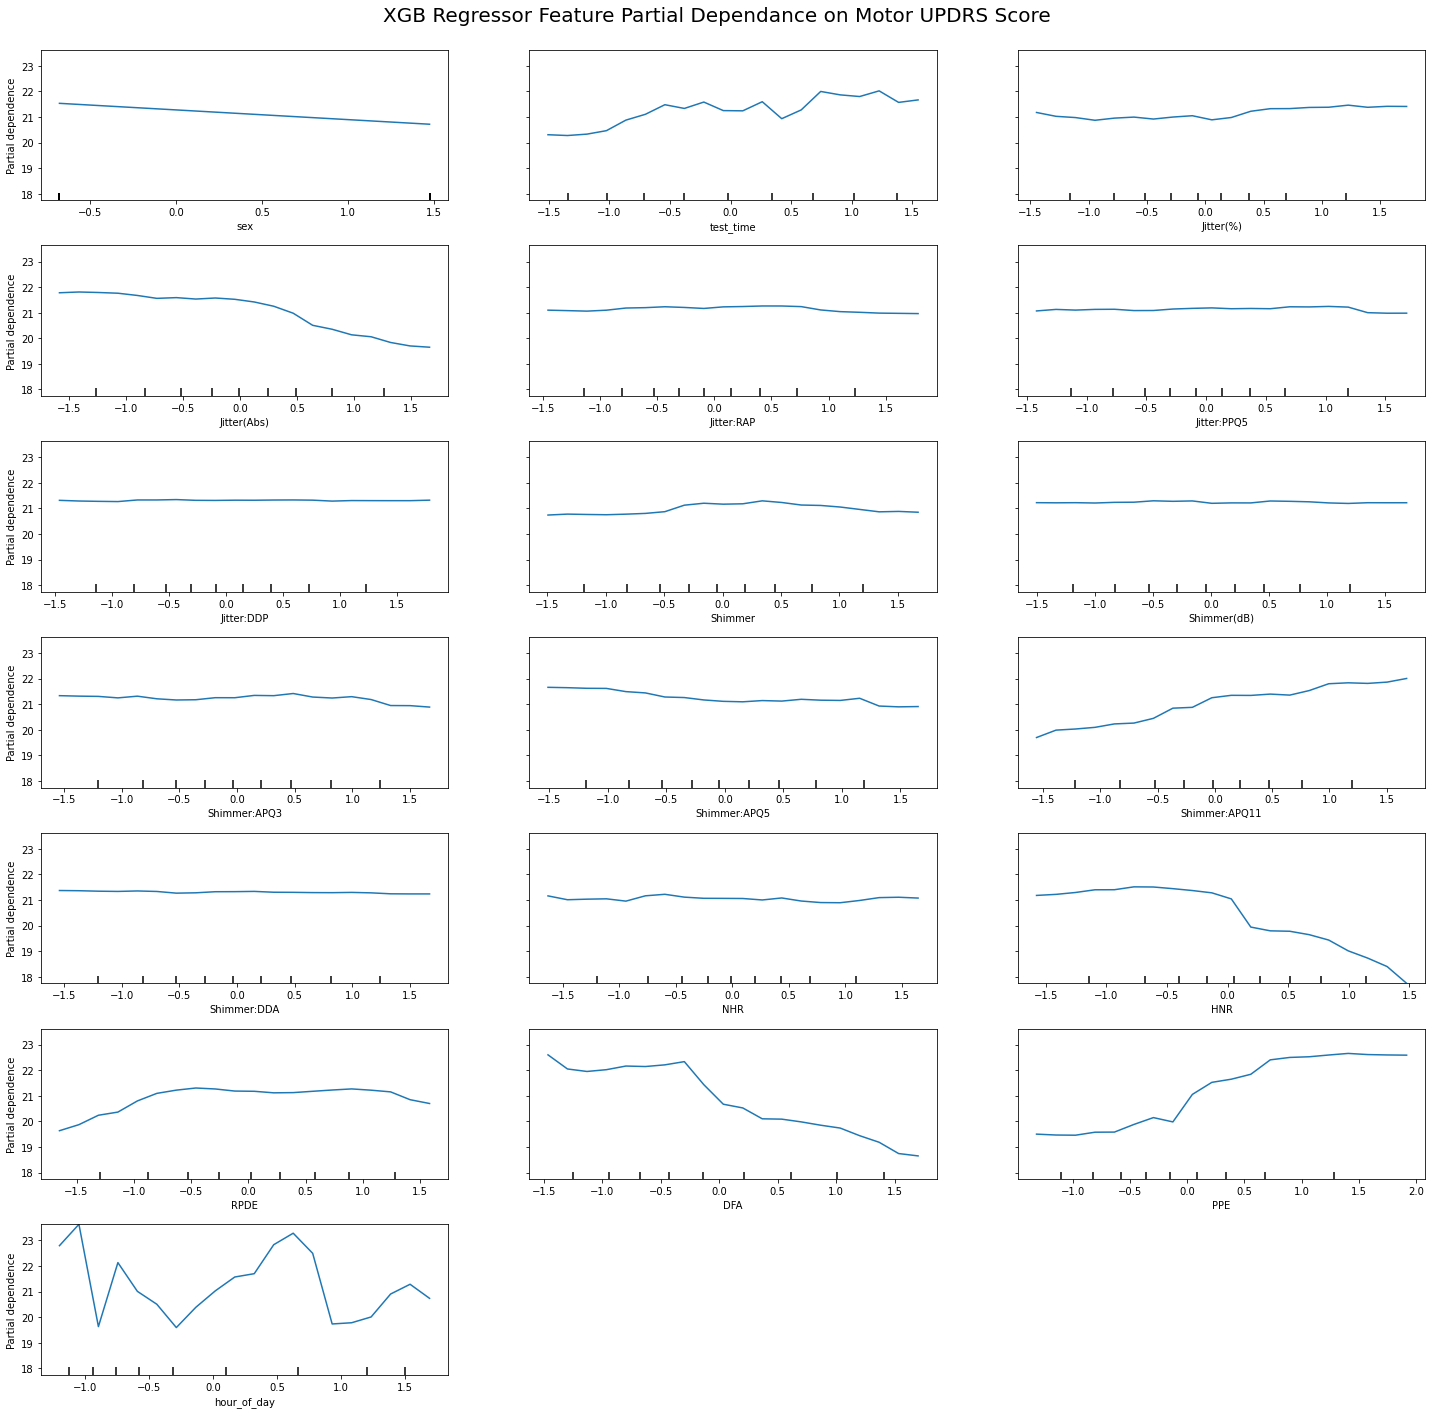

In [169]:
# Transform X_train data outside of pipeline for partial dependance chart
ohe = OneHotEncoder(use_cat_names=True).fit(X_train)
ohe_dat = ohe.transform(X_train)
sc = StandardScaler().fit(ohe_dat)
sc_dat = sc.transform(ohe_dat)
X_trans = pd.DataFrame(sc_dat, columns=ohe_dat.columns)

# Define our final model outside of a pipeline for the partial dependence plot
model_final_st = XGBRegressor(random_state=42, n_jobs=-1,
                 subsample=0.8,
                 n_estimators=1000,
                 max_depth=10,
                 learning_rate=0.01,
                 colsample_bytree=0.9
                )
model_final_st.fit(X_trans,np.ravel(y_train))

# Add in a dummy feature to facilitate partial dependance chart
model_final_st.dummy_ = "dummy"

# Run Partial Depdendance plot
features = ohe_dat.columns
plot_partial_dependence(model_final_st, X=X_trans, features=features,
                        n_jobs=-1, grid_resolution=20)

# Adjust figure properties
fig = plt.gcf()
fig.set_size_inches(20, 20)
fig.subplots_adjust(hspace=0.3)
fig.suptitle('XGB Regressor Feature Partial Dependance on Motor UPDRS Score',fontsize=20);
fig.tight_layout()
fig.subplots_adjust(top=0.95)

### Feature Importances
- This plot visualizes the 'gini' values for the features used to tune our XGB Regressor model
- The larger the 'gini' value the more important the feature was in predicting the motor UPDRS score

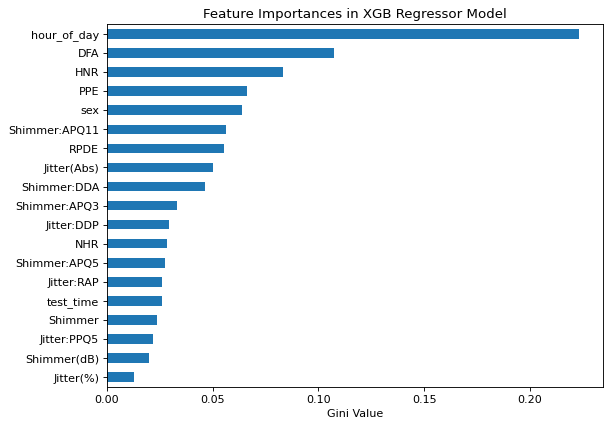

In [165]:
figure(figsize=(8, 6), dpi=80)

importances = model_final.named_steps['xgbregressor'].feature_importances_
features = model_final.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(data=importances,index=features).sort_values()
fig = feat_imp.plot(kind='barh',)
fig.set_xlabel('Gini Value')
fig.set_title('Feature Importances in XGB Regressor Model');

### Permutation Testing
- Check to see if feature importance order remains the same

In [166]:
# Generate permutation importance mean and standard deviation values
perm_imp = permutation_importance(model_final, X_val, y_val, random_state=42)
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
# Store values in a dataframe and sort by largest mean permutation importance value
df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')
df_perm.sort_values('imp_mean',ascending=False,inplace=True)
df_perm

,imp_mean,imp_std
hour_of_day,0.543317,0.015438
DFA,0.243879,0.014527
PPE,0.209538,0.024569
HNR,0.187713,0.028176
Jitter(Abs),0.161620,0.014427
test_time,0.133057,0.002694
sex,0.091514,0.014273
RPDE,0.079713,0.015286
Shimmer:APQ11,0.066020,0.013860
NHR,0.044104,0.005951


## Final Model Test Data Scores
- Calculate MAE, R-Squared, and RMSE metrics
- Plot scores for train, val, and test data chunks

#### Model Scores to beat from study
- LS: least squares - linear regression: train mae 6.7, test mae 6.7
- IRLS: least squares with weighting on outliers: train mae 6.7, test mae 6.7
- lasso: ridge linear regression: train mae 6.8, test mae 6.8
- CART: linear regression tree: train mae 4.5, test mae 5.8

,MAE,R2,RMSE
X_train,0.000434,1.000000,0.000599
X_val,3.004511,0.702182,4.376586
X_test,3.006283,0.714305,4.250988


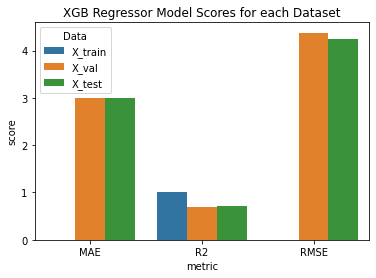

In [167]:
# Define datasets
X_lst = [X_train,X_val,X_test]
y_lst = [y_train,y_val,y_test]
row_lst=[]
# Loop through each dataset and calculate metrics.  Add to a list.
for i, data in enumerate(X_lst):
    row_lst.append([
        mean_absolute_error(y_lst[i],model_final.predict(data)),
        r2_score(y_lst[i],model_final.predict(data)),
        mean_squared_error(y_lst[i],model_final.predict(data))**0.5
    ])
# Form a dataframe
df_evals_f = pd.DataFrame(data =row_lst, index=['X_train','X_val','X_test'], columns = ['MAE','R2','RMSE'])
display(df_evals_f)
# Prepare dataframe for plotting
df_evals_f = df_evals_f.reset_index().rename(columns={'index':'Data'})
df_evals_ed_f = pd.melt(df_evals_f, id_vars='Data', var_name="metric", value_name="score")
# Create seaborn bar plot
sns.barplot(x = 'metric',y = 'score',hue = 'Data',data = df_evals_ed_f).set_title('XGB Regressor Model Scores for each Dataset');